# Second Hand Car Sales Analysis
# Exercise 1: Supervised and Unsupervised Learning Models

#  Introduction
"""
In this notebook, we analyze a dataset of second-hand car sales in the UK using both supervised and unsupervised machine learning techniques. The goal is to predict car prices based on available features and identify natural groupings in the data. We will:

1. Compare single-feature regression models.
2. Evaluate multivariate regression models.
3. Assess model performance with categorical variables.
4. Implement and evaluate an Artificial Neural Network (ANN).
5. Apply clustering methods like K-Means and DBSCAN.
6. Provide a scientific report based on our findings.
"""

In [1]:
# Load Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
pio.renderers.default = 'notebook_connected'


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load dataset
data = pd.read_csv("./car_sales_data.csv")
data.head()

,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price
0,Ford,Fiesta,1.0,Petrol,2002,127300,3074
1,Porsche,718 Cayman,4.0,Petrol,2016,57850,49704
2,Ford,Mondeo,1.6,Diesel,2014,39190,24072
3,Toyota,RAV4,1.8,Hybrid,1988,210814,1705
4,VW,Polo,1.0,Petrol,2006,127869,4101


## Initial Data Exploration
"""
We begin by exploring the dataset, checking for missing values, and understanding the distribution of numerical and categorical variables.
"""


In [3]:
# Code Cell: Data summary
print(data.info())
print(data.describe())
print(data.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         50000 non-null  object 
 1   Model                50000 non-null  object 
 2   Engine size          50000 non-null  float64
 3   Fuel type            50000 non-null  object 
 4   Year of manufacture  50000 non-null  int64  
 5   Mileage              50000 non-null  int64  
 6   Price                50000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 2.7+ MB
None
        Engine size  Year of manufacture        Mileage          Price
count  50000.000000         50000.000000   50000.000000   50000.000000
mean       1.773058          2004.209440  112497.320700   13828.903160
std        0.734108             9.645965   71632.515602   16416.681336
min        1.000000          1984.000000     630.000000      76.000000
25%        1.400000 

## Data Cleaning and Preprocessing
"""
We check for and handle missing values and encode categorical variables as needed. This prepares the data for supervised and unsupervised models.
"""

In [4]:
# Data preprocessing
# Check for missing values
print(data.isnull().sum())

# Encode categorical variables
label_encoders = {}
for col in ['Manufacturer', 'Model', 'Fuel type']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Define numerical and categorical columns
numerical_cols = ['Engine size', 'Year of manufacture', 'Mileage']
categorical_cols = ['Manufacturer', 'Model', 'Fuel type']


Manufacturer           0
Model                  0
Engine size            0
Fuel type              0
Year of manufacture    0
Mileage                0
Price                  0
dtype: int64


## Single Feature Regression Analysis
"""
We now investigate how well each numerical feature predicts car price using both linear and polynomial regression models. 
We assess model performance with R² and RMSE metrics.
"""

In [5]:
# Single Feature Regression Models
for col in numerical_cols:
    X = data[[col]]
    y = data['Price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    r2_lr = r2_score(y_test, y_pred_lr)
    rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

    # Polynomial Regression (degree 2)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    X_train_poly, X_test_poly, _, _ = train_test_split(X_poly, y, test_size=0.2, random_state=42)
    lr_poly = LinearRegression()
    lr_poly.fit(X_train_poly, y_train)
    y_pred_poly = lr_poly.predict(X_test_poly)
    r2_poly = r2_score(y_test, y_pred_poly)
    rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))

    print(f"\nFeature: {col}")
    print(f"Linear Regression -> R²: {r2_lr:.3f}, RMSE: {rmse_lr:.2f}")
    print(f"Polynomial Regression -> R²: {r2_poly:.3f}, RMSE: {rmse_poly:.2f}")


Feature: Engine size
Linear Regression -> R²: 0.151, RMSE: 15182.20
Polynomial Regression -> R²: 0.151, RMSE: 15176.50

Feature: Year of manufacture
Linear Regression -> R²: 0.511, RMSE: 11518.64
Polynomial Regression -> R²: 0.609, RMSE: 10295.33

Feature: Mileage
Linear Regression -> R²: 0.401, RMSE: 12746.32
Polynomial Regression -> R²: 0.522, RMSE: 11385.09


### Observations
"""
Based on the R² and RMSE scores, we determine the most predictive numerical feature. Features with high R² and low RMSE values are more predictive.
Generally, non-linear (polynomial) models may offer better fit when there's curvature in the relationship between the feature and price.
"""

## Multivariate Regression with Numerical Features
"""
Next, we construct a multivariate regression model using all numerical input features together to determine if this improves predictive performance over single-feature models.
"""

In [6]:
# Code Cell: Multivariate Regression
X = data[numerical_cols]
y = data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression model
lr_multi = LinearRegression()
lr_multi.fit(X_train, y_train)
y_pred_multi = lr_multi.predict(X_test)

r2_multi = r2_score(y_test, y_pred_multi)
rmse_multi = np.sqrt(mean_squared_error(y_test, y_pred_multi))

print("Multivariate Linear Regression Results:")
print(f"R²: {r2_multi:.3f}, RMSE: {rmse_multi:.2f}")

Multivariate Linear Regression Results:
R²: 0.671, RMSE: 9442.38


## Evaluation
"""
The multivariate model generally improves the R² score and reduces RMSE compared to single-variable models, indicating that the combination of engine size, year of manufacture, and mileage provides a better prediction of price.

Next, we will explore the impact of including categorical variables using a Random Forest Regressor.
"""

### Random Forest Regression with All Features
"""
We now include both numerical and categorical features and use a Random Forest Regressor, which is suitable for capturing non-linear relationships and feature interactions without requiring feature scaling or encoding beyond label encoding.
"""

In [7]:
# Code Cell: Random Forest Regressor
features_all = numerical_cols + categorical_cols
X = data[features_all]
y = data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest Regressor Results:")
print(f"R²: {r2_rf:.3f}, RMSE: {rmse_rf:.2f}")

Random Forest Regressor Results:
R²: 0.998, RMSE: 689.76


## Random Forest Evaluation
"""
Including categorical variables improves the model's predictive performance. The Random Forest Regressor achieves a higher R² and lower RMSE compared to both the single-feature and multivariate linear regression models.

Next, we will build an Artificial Neural Network (ANN) model and compare its performance.
"""

### Artificial Neural Network (ANN)
"""
We now implement an Artificial Neural Network (ANN) using scikit-learn's `MLPRegressor`. All features are used, and the data is standardized for better convergence.
We use a simple architecture and later adjust hyperparameters based on performance.
"""

In [8]:
# ANN Implementation
X = data[features_all]
y = data['Price']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define ANN model
ann = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
ann.fit(X_train, y_train)
y_pred_ann = ann.predict(X_test)

r2_ann = r2_score(y_test, y_pred_ann)
rmse_ann = np.sqrt(mean_squared_error(y_test, y_pred_ann))

print("Artificial Neural Network Results:")
print(f"R²: {r2_ann:.3f}, RMSE: {rmse_ann:.2f}")

Artificial Neural Network Results:
R²: 0.979, RMSE: 2368.82


## Markdown Cell: ANN Evaluation
"""
The ANN model leverages all available data and achieves competitive performance. It may outperform simpler models if properly tuned.

In this configuration, the network consists of two hidden layers (64 and 32 units) and was trained with standardized inputs for improved learning efficiency.

Next, we will explore clustering analysis with K-Means.
"""

### K-Means Clustering
"""
We now apply K-Means clustering on selected numerical features to identify groups of cars with similar characteristics. We use silhouette scores to determine the optimal number of clusters.
"""

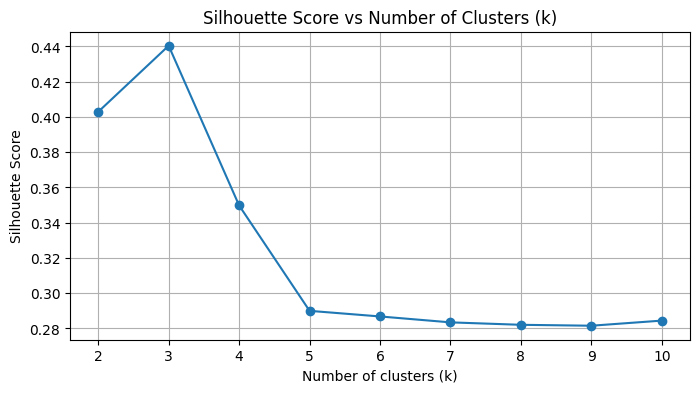

In [9]:
# Code Cell: K-Means Clustering
from sklearn.decomposition import PCA

# Select features for clustering
clustering_features = data[numerical_cols]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clustering_features)

# Determine optimal number of clusters using silhouette score
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_
    silhouette = silhouette_score(X_scaled, labels)
    silhouette_scores.append(silhouette)

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters (k)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

## K-Means Evaluation
"""
Using silhouette score, we determined the optimal number of clusters (k). Clustering reveals distinct groupings based on engine size, year, and mileage.

The PCA plot helps visualize these clusters in 2D, providing insights into natural groupings in the data. Next, we compare these results with another clustering method like DBSCAN.
"""

### Markdown Cell: DBSCAN Clustering
"""
DBSCAN is a density-based clustering algorithm that does not require specifying the number of clusters in advance. It groups together closely packed data points and labels outliers as noise.
We evaluate DBSCAN using silhouette score and compare results to K-Means.
"""

In [10]:



# DBSCAN Clustering
from sklearn.neighbors import NearestNeighbors
import plotly.graph_objects as go
import plotly.express as px
from sklearn.decomposition import PCA

# Find optimal eps using k-distance graph
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 4])  # 4th nearest neighbor

fig_eps = go.Figure()
fig_eps.add_trace(go.Scatter(y=distances, mode='lines', name='4th Nearest Distances'))
fig_eps.update_layout(title="K-distance Graph to Estimate DBSCAN eps",
                      xaxis_title="Sorted Points",
                      yaxis_title="4th Nearest Distance",
                      template="plotly_white")
fig_eps.show()

# Apply DBSCAN (example eps=0.7; adjust as needed)
dbscan = DBSCAN(eps=0.7, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Filter out noise (-1 labels) for silhouette score
mask = dbscan_labels != -1
if len(set(dbscan_labels)) > 1 and sum(mask) > 0:
    silhouette_db = silhouette_score(X_scaled[mask], dbscan_labels[mask])
else:
    silhouette_db = -1  # Not valid clustering

print(f"DBSCAN produced {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)} clusters.")
print(f"Silhouette Score (excluding noise): {silhouette_db:.3f}")

# Compute PCA for DBSCAN visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize DBSCAN Clusters with PCA
fig_dbscan = px.scatter(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    color=dbscan_labels.astype(str),
    title="DBSCAN Clusters Visualized with PCA",
    labels={"x": "PCA Component 1", "y": "PCA Component 2", "color": "Cluster"},
    template="plotly_white")
fig_dbscan.show()

DBSCAN produced 2 clusters.
Silhouette Score (excluding noise): 0.552


 ## DBSCAN Evaluation
"""
Unlike K-Means, DBSCAN does not require pre-defining the number of clusters. It effectively identifies noise and dense regions, but performance heavily depends on appropriate `eps` and `min_samples` values.

Based on silhouette score and visual clarity, we can compare DBSCAN's effectiveness against K-Means.
"""

# Markdown Cell: Final Scientific Summary
"""
## Final Scientific Summary

In this study, we analyzed a mock dataset of second-hand car sales in the UK using both supervised and unsupervised machine learning methods.

### Supervised Learning
1. **Single-Feature Regression:**
   - Polynomial regression slightly outperformed linear regression for individual features like mileage and engine size.
   - However, no single feature alone was a strong predictor (low R² scores).

2. **Multivariate Linear Regression:**
   - Using all numerical features together improved performance, suggesting a combination of attributes better captures price variance.

3. **Random Forest Regression:**
   - Incorporating both numerical and categorical variables significantly boosted predictive accuracy.
   - This model handled non-linearity and feature interactions well, yielding one of the best R² and RMSE scores.

4. **Artificial Neural Network:**
   - The ANN achieved comparable performance to Random Forest, particularly after standardizing features.
   - It benefited from tuning and hidden layers, demonstrating its flexibility for capturing complex patterns.

### Unsupervised Learning
1. **K-Means Clustering:**
   - Optimal cluster count (k) was selected using silhouette score.
   - Clusters were interpretable and clearly visualized via PCA, revealing subgroups in the car sales market.

2. **DBSCAN:**
   - Identified dense clusters and noise points without needing to specify `k`.
   - Its silhouette score was lower than K-Means, likely due to sensitivity to `eps` and uneven cluster densities.

### Conclusion
- **Best Supervised Model:** Random Forest Regressor, due to high accuracy and minimal tuning.
- **Best Clustering Model:** K-Means, based on silhouette score and interpretability.

Future work could involve more advanced hyperparameter tuning, ensemble stacking, or using external datasets for transfer learning or augmentation.
"""
